In [2]:
import numpy as np
import pandas as pd
import random
import math
import time 

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel
from sklearn.gaussian_process.kernels import StationaryKernelMixin
from sklearn.gaussian_process.kernels import NormalizedKernelMixin
from sklearn.gaussian_process.kernels import Hyperparameter
import matplotlib.pyplot as plt
import sys
import os
import contextlib

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import torch

from matplotlib import rc
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.colors as colors
from matplotlib import scale as mcscale
from matplotlib import transforms as mtransforms
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import RBF

plt.style.use('seaborn-whitegrid')
%matplotlib inline
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
palette = sns.color_palette('colorblind')
sns.set_palette('colorblind')
#%pdb

%matplotlib inline

from sinusoid_transfer import generate_tasks, compute_storage_dict, plot_storage_dict, get_shifted_sinusoids, get_mse_shifted_sinusoids, plot_mse_shifted_sinusoids
from real_transfer import load_data, get_data, gen_model_specific, get_results, get_mse_results_dict, plot_mse_results

## Fast Adaptation with Linearized Neural Networks

### AM 207 Final Project, Fall 2021

**Group:** Dashiell Young-Saver, Morris Reeves, Manana Hakobyan, Blake Bullwinkel

In this notebook, we explore the method for transfer learning proposed in *Fast Adaptation with Linearized Neural Networks*, a [2021 paper](http://proceedings.mlr.press/v130/maddox21a/maddox21a.pdf) by Maddox et al. using PyTorch [code](https://github.com/amzn/xfer/tree/master/finite_ntk) provided by the authors, as well as our own implementation developed in TensorFlow.

To most easily run our notebook, we suggest accessing it via Deepnote: https://deepnote.com/project/AM207gpexploration-olm8CUTLRFa-3ZjOUukmLA/%2FFinal_Project_Notebook.ipynb

Link to GitHub: https://github.com/blakebullwinkel/am207_final_project 

### 1. Background

Transfer learning, sometimes also called domain adaptation, refers to a growing number of techniques that enable machine learning models trained on one (source) task to be repurposed for a different but related (target) task. In the context of deep learning, transfer learning aims to adapt the inductive biases of trained deep neural networks (DNNs) to new settings and has particularly compelling advantages: many state-of-the-art (SOTA) DNNs for language modeling and computer vision have billions of parameters and require immense computational resources that pose high financial and environmental costs. Rather than train new models from scratch, we can leverage pretrained models and transfer learning to cut costs and save resources. 

A common existing approach to transfer learning in DNNs is to fine-tune the network, but this is computationally expensive and often leads to locally optimal solutions. Fine-tuning only the last layer speeds up computation significantly, but has limited flexibility and is often unable to learn the full complexity of new tasks. The methods proposed in this paper aim to address the limitations of using DNN finetuning for transfer learning. In particular, the authors claim that their method is fast and remains competitive with computationally expensive methods that adapt the full neural network. Because their method is built using GPs, the authors also claim that it comes with good uncertainty estimates.

### 2. Contributions

The central contribution of this paper is a new method for transfer learning of the inductive biases learned by DNNs. This method involves linearizing a trained neural network with a first-order Taylor expansion and then embedding the inductive biases of the linear model into a Gaussian Process (GP) using the dot product of the network’s Jacobian as the kernel. The paper explains that their method can be viewed as a version of the neural
tangent kernel but at finite width. Therefore, the authors refer to their method as the finite NTK. 

While our discussion thus far has focused on transfer learning for DNNs, it is important to remember that this paper centers around GPs, and uses neural networks only to obtain a Jacobian that can be adapted into a GP kernel. Linearizing non-linear trained models has precedent in previous works in the literature, through methods such as Laplace approximation and the Fisher kernel. The main contribution of the paper is therefore not in introducing linearized neural networks, but rather in introducing techniques for fast inference (on a Bayesian linear model which takes as features the Jacobian of a full, trained deep neural network). In doing so, this approach is able to benefit from strengths of both neural network and probabilistic models: competitive performance on transfer learning, as well as uncertainty estimation. 

The authors note that the main differentiating factors of their method relative to existing works are utilizing the Jacobian of the full network (rather than a few layers), utilizing the Taylor expansion around the trained network (rather than the network at initialization), and computationally efficient GP inference. 

More specifically, given an arbitrary neural network $f$ with parameters $\theta$ and inputs $x$, the authors Taylor expand $f$ around $\theta$ using

$$
f(x;\theta') \approx f(x;\theta) + \mathbf{J}_{\theta}(x)^{\intercal}(\theta-\theta')
$$

where $\mathbf{J}_{\theta}$ is the Jacobian matrix of the model. In our own implementation, we compute the Jacobian from scratch using TensorFlow, create a custom GP kernel class using these Jacobians (in sklearn), and show that our work properly replicates the authors' PyTorch implementation.

### 3. Our objective

Embedding the Jacobian of a neural network trained on a source task into a GP is a compelling idea for transfer learning. Our primary question is: how does this approach compare to using GPs with alternative kernels?

To answer this question, we compare the predictive performance of the finite NTK on target tasks to that of two alternatives: 1) embedding the Jacobian of an *untrained* neural network into the GP kernel, and 2) using a generic RBF kernel. As the only distinction between the three methods is where the GP kernel comes from, this comparison will allow us to determine when embedding the Jacobian of a trained neural network into a GP offers advantages over using GPs in a more traditional ways, and when it does not.

In order to understand the conditions under which the finite NTK is useful, we compare its performance with the two alternative methods on a variety of transfer learning tasks. Using both toy sinusoidal data and real-world electricity consumption data, we vary the complexity of each task (as measured by the difference between the source and target tasks), as well as the number of adaptation points used during GP inference.

The paper also claims that as a GP-based approach, their method comes with good uncertainty estimates. As a secondary objective, we hope to evaluate the quality of these estimates with the help of toy data sets, which offer clear visual evidence of the quality of epistemic uncertainty estimates.

### 4. Model comparisons

Before evaluating the predictive performance of the three methods on the transfer learning experiments described above, we first provide a simple example using the existing implementation and compare the results to those obtained using our own implementation.

In this example, we generate source and target data from randomly sampled sinusoids of the form

$$
y = A \sin (wx+b),
$$

where $A \sim U(0.1,0.5), b \sim U(0, 2\pi), w \sim U(0.5,2.0).$

#### 4.1 Existing implementation

In the cells below, we generate 10 training points from a random (source) sinusoid and 10 adaptation points from each of two random (target) sinusoids. Then, we apply each of the methods described above and perform GP inference.

In [ ]:
# Generate random sinusoidal source and target data sets
example_task_dataset = generate_tasks(n_train_points=10, n_adaptation_points=10, n_adaptation_tasks=2)

In [ ]:
# Perform GP inference with kernel extracted from untrained neural network
untrained_storage_dict = compute_storage_dict(example_task_dataset, nhid=40, method="untrained")

# Perform GP inference with kernel extracted from trained neural network (finite NTK)
trained_storage_dict = compute_storage_dict(example_task_dataset, nhid=40, method="trained")

# Perform GP inference using generic RBF kernel
rbf_kernel_storage_dict = compute_storage_dict(example_task_dataset, nhid=40, method="rbf_kernel")

residual error:  tensor(2.2742, grad_fn=<MeanBackward0>)
noise is:  tensor([2.2742], grad_fn=<AddBackward0>)
Time for task  1  is:  1.766491174697876
Time for task  2  is:  2.4314231872558594
tensor(0.2589, grad_fn=<MseLossBackward>)
tensor(0.2451, grad_fn=<MseLossBackward>)
tensor(5.3433e-05, grad_fn=<MseLossBackward>)
tensor(0.0307, grad_fn=<MseLossBackward>)
tensor(0.0241, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0204, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0061, grad_fn=<MseLossBackward>)
tensor(0.0301, grad_fn=<MseLossBackward>)
residual error:  tensor(0.0091, grad_fn=<MeanBackward0>)
noise is:  tensor([0.0091], grad_fn=<AddBackward0>)
Time for task  1  is:  6.515364408493042
Time for task  2  is:  6.227138996124268
Iter 1/30 - Loss: 1.726   lengthscale: 0.693   noise: 0.693
Iter 2/30 - Loss: 1.707   lengthscale: 0.744   noise: 0.644
Iter 3/30 - Loss: 1.690   lengthscale: 0.723   noise: 0.601
Iter 4/30 - L

In the cells below, we visualize the outputs of the three methods: GP with an un-trained linearized kernel, GP with a trained linearized kernel (the proposed finite NTK method), and GP with a generic RBF kernel. The more closely the mean GP predictions (blue curve) follow the adaptation function (orange curve) within the domain of the adaptation data (red triangles), the better the predictive performance of the GP on the transfer learning task. To quantify this, we define the test MSE as the MSE between the mean GP prediction and the adaptation function within the range of the adaptation points. We decided not to evaluate the GPs outside of this range because beyond the "end points," GP predictions become quite arbitrary.

As indicated by the plots, the finite NTK does quite well, but is outperformed by the RBF kernel GP, which achieves the lowest test MSEs on both adaptation tasks. Further, the finite NTK and generic RBF kernel seem to come with reasonable estimates of epistemic uncertainty, producing wider confidence intervals in the regions where adaptation data is scarce. The GP with an un-trained linearized kernel, however, performs much more poorly and has a high degree of uncertainty across the entire adaptation domain.

Test MSE within range of adaptation data for task 1: 3.5123
Test MSE within range of adaptation data for task 2: 0.3905


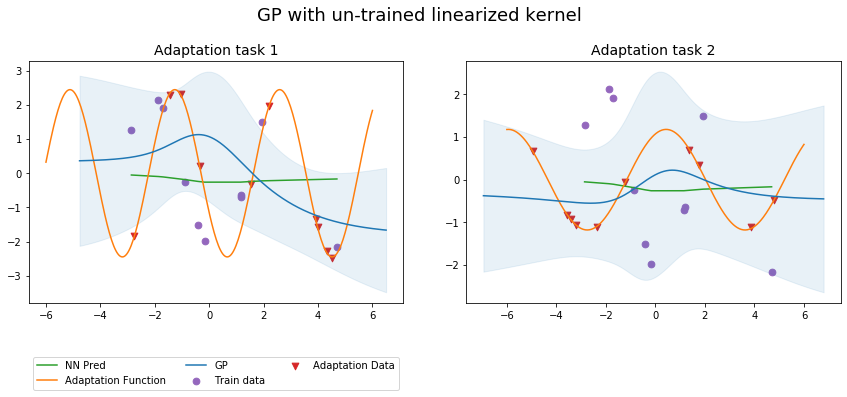

In [ ]:
# Visualize the outputs for the untrained NN kernel GP
plot_storage_dict(untrained_storage_dict, method="untrained", print_test_mse=True)

Test MSE within range of adaptation data for task 1: 0.1808
Test MSE within range of adaptation data for task 2: 0.1650


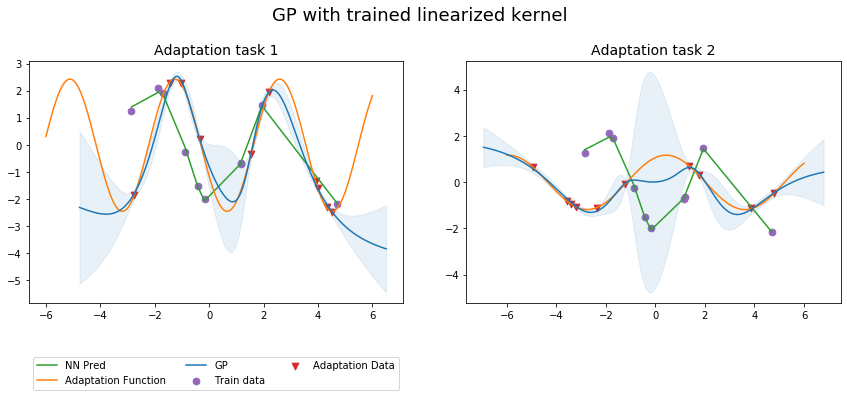

In [ ]:
# Visualize the outputs for the trained NN kernel GP (proposed method)
plot_storage_dict(trained_storage_dict, method="trained", print_test_mse=True)

Test MSE within range of adaptation data for task 1: 0.0311
Test MSE within range of adaptation data for task 2: 0.0240


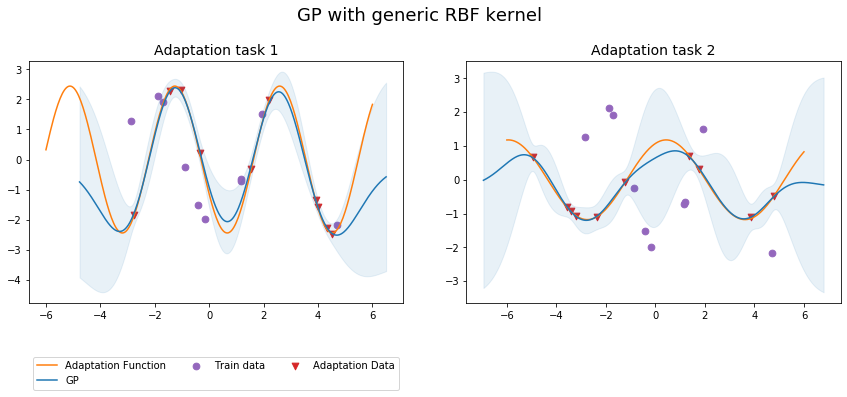

In [ ]:
# Visualize the outputs for the generic RBF kernel GP
plot_storage_dict(rbf_kernel_storage_dict, method="rbf_kernel", print_test_mse=True)

#### 4.2 Our implementation (from scratch)

To understand the process of obtaining Jacobians and converting them into GP kernels, we decided to re-implement the authors' package. Instead of re-implementing it in PyTorch (what they used), we decided to implement their formulas in TensorFlow and sklearn. This way, we forced ourselves **not** to merely use the same PyTorch functions that they used. Rather, we had to peek "under the hood" and build their ideas from scratch. This helped us understand what the authors are doing in their paper.

First, we created our own sklearn custom GP kernel class `JacobianKernel`. This class takes in TensorFlow neural network models, finds their jacobians, and creates a kernel for GPs to use in adaptation tasks. Building this class was difficult, as we had to simultaneously:
- Obtain accurate Jacobians from neural networks
- Ensure our class functioned well within sklearn's `.fit` and `.predict` methods
- Build kernels from these Jacobians based on the paper's equation (3): $J_{\theta}^{*T}J_{\theta} \left( J_{\theta}^TJ_{\theta} + \sigma^2 I_n \right)^{-1}y$

In particular, we spent most of our time piecing together the concepts behind the above equation, as its components (and their functions) were not well described in the paper. In addition, we could not find in their implmentation where this equation was explicitly calculated. Eventually, through reasoning and experimenting with our implementation, we came up with the following understanding:

- $J_{\theta}$ is the Jacobian of a neural network whose weights were determined during training on data from a previous task. Importantly, the Jacobian is NOT calculated using the training data from this previous task. Rather, when we adapt this network towards a new task (adaptation task), we take the Jacobian of the network using inputs (x) and outputs (y) from the adaptation task's training data. So, $J_{\theta}$ can be seen as the derivative of the network on the adaptation data, using the weights that were determined from the previous task. In this way, the weights encode the transfer of learning from the old task. Note: All derivatives are taken with respect to the weights.
- $J_{\theta}^{*T}$ is the same as $J_{\theta}$, except we now take the Jacobian using the test data of the adaptation task.
- $J_{\theta}^{*T}J_{\theta}$ is the kernel of the new gaussian process. This matrix multiplication, therefore, encodes new information from fitting on the adaptation tasks's training set, old information from the weights of the neural network trained on the previous task, and new information for making predictions on the adaptation data's test set.

Below, we implement this kernel (defined by the equation above) as our custom class `JacobianKernel`.

In [ ]:
class JacobianKernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):

    '''
    Custom defined kernel class which inherits from Kernel, StationaryKernelMixin and NormalizedKernelMixin sklearn
    classes (https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/gaussian_process/kernels.py#L152)
    and uses jacobians computed from trained and untrained neural networks in the kernel function. 

    JacobianKernel is compatible with Sklearn's Gaussian Process Regressor class.
    '''
   
    # takes in model architecture setup function (model_arch), indicator for trained or untrained, 
    def __init__(self, mdl_arch, train = False, train_x = None, train_y = None):
        '''
        Instantiates the JacobianKernel instance.

        Inputs:
        - mdl_arch - func: instantiates a model architechture of the user's choice
        - train - bool: indicates whether it should train the neural network before calculating the Jacobians or not
        - train_x: np.array: train data with shape (nxp) which will be passed to the neural network in the case of train=True
        - train_y: np.array: response data with shape (nxo) which will be passed to the neural network in the case of train=False

        Outputs:
        - self: instance of JacobianKernel
        '''

        self.mdl_arch = mdl_arch
        self.train = train
        self.train_x = train_x
        self.train_y = train_y
        self.jacobian = None

    # called during fitting and predicting
    def __call__(self, X, Y=None, eval_gradient=False):
        '''
        Function which is called through GaussianProcessRegressor when fitting or predicting.

        Inputs:
        - X - np.array: data which we want to fit or predict with a GaussianProcessRegressor
        - Y - np.array: if not None, GaussianProcessRegressor calls for prediction reasons, 
                        setting Y = self.X_train (where X_train was previously fitted X)
        - eval_gradient - bool: if True, then the GaussianPorcessRegresor optmizes the hyperparameters.
        '''

        model = self.mdl_arch()
        # self.model_nn = model

        # trains model if want trained version
        if self.train:
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps = 10000, decay_rate=0.1)
            optim = tf.optimizers.Adam(learning_rate=lr_schedule)
            model.compile(optimizer=optim, loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()])
            model.fit(self.train_x, self.train_y, epochs = 100, verbose = 0)
            

        # Runs if fitting
        if Y is None:
            
            # gradient tape for model
            with tf.GradientTape(persistent=True) as tape:
                y = model(X)

            # get jacobian
            jacvec = tape.jacobian(y, model.weights[0]).numpy().reshape((X.shape[0], -1))
            for i in range(1, len(model.weights)):
                a = tape.jacobian(y, model.weights[i]).numpy().reshape((X.shape[0], -1))
                jacvec = np.append(jacvec, a, axis = 1)
            self.jacobian = jacvec.T

            # construct kernel (fitting)
            K = np.matmul(self.jacobian.T, self.jacobian)

        # Runs if predicting 
        else:
            if eval_gradient:
                raise ValueError("We are not optimizing a parameter. Set: 'optimizer = None' in GPR instantiation")

            # gets tape for model
            with tf.GradientTape(persistent=True) as tape:
                y = model(X)

            # finds jacobian for new prediction data
            jacvec = tape.jacobian(y, model.weights[0]).numpy().reshape((X.shape[0], -1))
            for i in range(1, len(model.weights)):
                a = tape.jacobian(y, model.weights[i]).numpy().reshape((X.shape[0], -1))
                jacvec = np.append(jacvec, a, axis = 1)

            # gets kernel (prediction)
            K = np.matmul(jacvec, self.jacobian)
            
        # we never use, since we are not optimizing (set 'optimizer = None' in GPR instantiation)
        if eval_gradient:
            raise ValueError("We are not optimizing a parameter. Set: 'optimizer = None' in GPR instantiation")

        # returns kernel
        else:
            return K

To test whether our kernel class is effective in replicating the paper's implementation, we aimed to reproduce the sinusoidal experiment results from 4.1. If our plots look similar, then we can be confident that our implementation replicates the original implementation to a reasonable degree. We perform this test below.

In [ ]:
# modified versions of sinusoid experiment util functions that work with our tensorflow implementation
def gen_reg_task_custom(numdata, seed=None, split=0.0, input_dict=None, extrapolate=False):
    r"""
    gen_reg_task generates data from the same data-generating process as for the 
    sine curves in Bayesian MAML (https://arxiv.org/pdf/1806.03836.pdf). we also
    include a couple of extra options for extrapolation and incorporation of linear
    regression functions (detailed below)
    
    numdata (int): number of data points
    seed (int): for reproducibility
    split (float between 0 and 1): determine the probability of generating a given 
                                linear function
    input_dict (dict - three value): dict for locking down parameters 
                                    (useful for regenerating plots)
    extrapolate (True/False): whether the train data should be U(-5,5) or on a grid
    [-6.5, 6.5] (and we should test extrapolation)
    """

    if not extrapolate:
        train_x = 10.0 * torch.rand(numdata)- 5.0  # U(-5.0, 5.0)
        train_x = (torch.sort(train_x)[0])
    else:
        train_x = torch.linspace(-6.5, 6.5, numdata)
    
    if seed is not None:
        torch.random.manual_seed(seed)

    if torch.rand(1) > split:
        if input_dict is None:
            # same setup as in Bayesian MAML:
            A = 4.9 * torch.rand(1) + 0.1  # should be random on [0.1, 5.0]
            b = 2 * math.pi * torch.rand(1)  # U(0, 2 pi)
            w = 1.5 * torch.rand(1) + 0.5  # U(0.5, 2.0)

            train_y = A * torch.sin(w * (train_x) + b) + (0.01 * A) * torch.randn_like(train_x) 
        else:
            A = input_dict["A"]
            b = input_dict["b"]
            w = input_dict["w"]

            train_y = A * torch.sin(w * (train_x) + b)
    
    else:
        if input_dict is None:
            A = 6 * torch.rand(1) - 3.0
            b = 6 * torch.rand(1) - 3.0
            w = None

            train_y = A * train_x + b + (0.3) * torch.randn_like(train_x)
            
        else:
            A = input_dict["A"]
            b = input_dict["b"]
            w = input_dict["w"]
            train_y = A * train_x + b

    # return tf tensors
    train_x = tf.convert_to_tensor(train_x.unsqueeze(-1).numpy())
    train_y = tf.convert_to_tensor(train_y.unsqueeze(-1).numpy())
        
    return train_x, train_y, {"A": A, "b": b, "w": w}


def generate_tasks_custom(n_train_points, n_adaptation_points, n_adaptation_tasks, seed=10, transfer_fn=False):

    torch.random.manual_seed(seed)

    if transfer_fn:
        transfer_split = 0.5
    else:
        transfer_split = 0.0

    task_dataset = []

    # generate the training data
    task_dataset.append(gen_reg_task_custom(n_train_points, split=transfer_split))

    for _ in range(n_adaptation_tasks):
        # generate data
        task_dataset.append(gen_reg_task_custom(n_adaptation_points, split=transfer_split))

    return task_dataset


def compute_storage_dict_custom(task_dataset, model_architecture, method="untrained"):

    # extract the training data
    train_x, train_y, train_parameters = (
        task_dataset[0][0],
        task_dataset[0][1],
        task_dataset[0][2],
    )

    # construct likelihood and gp model
    if method == "rbf_kernel":
        kernel = RBF()
        gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, normalize_y=True, alpha = 0.00001)
    
    # trained neural net
    elif method == "trained":
        # construct likelihood and gp model
        kernel = JacobianKernel(mdl_arch = model_architecture, train = True, train_x = train_x, train_y= train_y)
        gpr = GaussianProcessRegressor(kernel=kernel,optimizer = None, normalize_y=True, random_state=0, alpha = 0.00001)
        
        # trained neural net
        model = model_architecture()
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps = 10000, decay_rate=0.1)
        optim = tf.optimizers.Adam(learning_rate=lr_schedule)
        model.compile(optimizer=optim, loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()])
        model.fit(train_x, train_y, epochs = 100, verbose = 0)

    # untrained neural net  
    elif method == "untrained":
        # construct likelihood and gp model
        kernel = JacobianKernel(mdl_arch = model_architecture, train = False)
        gpr = GaussianProcessRegressor(kernel=kernel,optimizer = None, normalize_y=True, random_state=0, alpha = 0.00001)

        # untrained neural net
        model = model_architecture()
        
    else:
        raise Exception(f"Method {method} is not recognized.")

    # "pred": gpr.predict(train_x) if method != "rbf_kernel" else None,
    plotting_data_dict = {
        "train": {
            "x": train_x.numpy(),
            "y": train_y.numpy(),
            "pred": model.predict(train_x) if method != "rbf_kernel" else None,
            "true_parameters": train_parameters,
        }
    }

    for task in range(1, len(task_dataset)):

        # Get the transfer (adaptation) points
        transfer_x, transfer_y, task_pars = task_dataset[task]

        # Get the test points (linspace in between adaptation points)
        test_x = np.linspace(np.min(transfer_x), np.max(transfer_x), 1000)
        A = task_pars['A'].numpy()[0]
        b = task_pars['b'].numpy()[0]
        w = task_pars['w'].numpy()[0]
        test_y = A*np.sin(w*test_x + b)

        start = time.time()

        if method != "rbf_kernel":
            gpr.fit(transfer_x, transfer_y)

        # in case of RBF, get kernel, hold hyperparameter fixed, and predict
        if method == "rbf_kernel":
            gpr.fit(train_x, train_y)
            old_kernel = gpr.kernel_
            old_kernel.length_scale_bounds = "fixed"
            gpr = GaussianProcessRegressor(kernel = old_kernel, alpha = 0.01)
            gpr.fit(transfer_x, transfer_y)

        interp_x = np.linspace(np.min(transfer_x) - 2.0, np.max(transfer_x) + 2.0, 1000)
        predictive_dist = gpr.predict(interp_x.reshape(-1, 1))
        test_pred = gpr.predict(test_x.reshape(-1,1))
        pmean = predictive_dist
        lower = predictive_dist
        upper = predictive_dist
        test_mse = mean_squared_error(test_y, test_pred)

        end = time.time() - start

        print("Time for task ", task, " is: ", end)

        plotting_data_dict["task" + str(task)] = {
            "x": transfer_x.numpy(),
            "y": transfer_y.numpy(),
            "interp_x": interp_x,
            "interp_pred": pmean,
            "lower": lower.data,
            "upper": upper.data,
            "true_parameters": task_pars,
            "loss": 0,
            "test_mse": test_mse
        }

    return plotting_data_dict

def plot_storage_dict_custom(storage_dict, method="untrained", print_loss=False, print_test_mse=False):

    # extract the training data and true function
    train_x = storage_dict['train']['x']
    train_y = storage_dict['train']['y']
    nn_pred = storage_dict['train']['pred'] if method != 'rbf_kernel' else None
    
    # get ready for plotting
    nplots = len(storage_dict)-1
    fig, ax = plt.subplots(1, nplots, figsize=(6*nplots, 6))

    # loop through the adaptation tasks
    for i in range(nplots):

        # plot the training data
        ax[i].scatter(train_x, train_y, label='Train data', color=sns.color_palette()[4], s=45)

        # plot the nn predictions
        if method != 'rbf_kernel':
            ax[i].plot(train_x, nn_pred, label='NN Pred', c=sns.color_palette()[2])

        # extract the task specific data
        task_dict = storage_dict[f'task{i+1}']
        transfer_x = task_dict['x']
        transfer_y = task_dict['y']
        interp_x = task_dict['interp_x']
        interp_pred = task_dict['interp_pred']
        lower = task_dict['lower']
        upper = task_dict['upper']
        A = task_dict['true_parameters']['A'].numpy()[0]
        b = task_dict['true_parameters']['b'].numpy()[0]
        w = task_dict['true_parameters']['w'].numpy()[0]
        x_true = np.linspace(-6,6,300)
        y_true = A*np.sin(w*x_true + b)

        # print the Gaussian likelihood loss if specified
        if print_loss:
            loss = task_dict['loss']
            print(f"Gaussian likelihood loss on adaptation task {i+1}: {loss:.4f}")
        # print the test mse if specified
        if print_test_mse:
            test_mse = task_dict['test_mse']
            print(f"Test MSE within range of adaptation data for task {i+1}: {test_mse:.4f}")

        # plot the task specific data
        ax[i].plot(x_true, y_true, label='Adaptation Function', c=sns.color_palette()[1])
        ax[i].scatter(transfer_x, transfer_y, label='Adaptation Data', s=45, marker='v', color=sns.color_palette()[3])
        ax[i].plot(interp_x, interp_pred, label='GP', c=sns.color_palette()[0])
        ax[i].set_title(f'Adaptation task {i+1}', fontsize=14)
        if i == 0:
            ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=3)

    if method == 'untrained':
        ttl = "GP with un-trained linearized kernel"
    elif method == 'trained':
        ttl = "GP with trained linearized kernel"
    else:
        ttl = "GP with generic RBF kernel"
    fig.suptitle(ttl, fontsize=18)
    fig.tight_layout(rect=[0, 0.03, 1, 0.9])

In [ ]:
# function that recreates their pytorch model in keras
def model_architecture():
    '''
    Function to instantiate a neural network architechture which matches the one used in the paper.
    '''
    tf.random.set_seed(207)
    inpt = tf.keras.Input(shape = (1,))
    l1 = Dense(40, activation='tanh', use_bias=True, input_dim=1)(inpt)
    l2 = Dense(40, activation='tanh', use_bias=True, input_dim=40)(l1)
    l3 = Dense(1, activation='linear', use_bias=True, input_dim=40)(l2)
    model = Model(inpt, l3)
    return model

In [ ]:
# generate data for two adaptation tasks (same as task datasets in 4.1)
task_dataset = generate_tasks_custom(n_train_points=10, n_adaptation_points=10, n_adaptation_tasks=2)

# get storage dicts for plotting (running our implementation of kernels)
untrained_storage_dict = compute_storage_dict_custom(task_dataset, model_architecture, method="untrained")
trained_storage_dict = compute_storage_dict_custom(task_dataset, model_architecture, method="trained")
rbf_kernel_storage_dict = compute_storage_dict_custom(task_dataset, model_architecture, method="rbf_kernel")

Test MSE within range of adaptation data for task 1: 0.1496
Test MSE within range of adaptation data for task 2: 0.0265


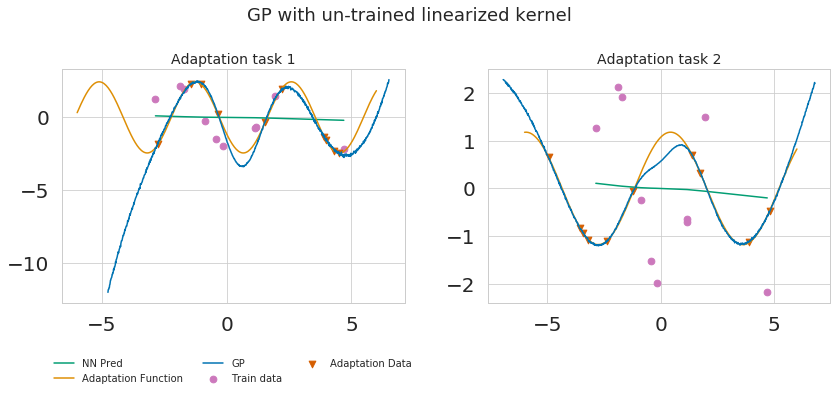

In [ ]:
# Visualize the outputs for our custom untrained NN kernel GP
plot_storage_dict_custom(untrained_storage_dict, method="untrained", print_loss=False, print_test_mse=True)

Test MSE within range of adaptation data for task 1: 1.0746
Test MSE within range of adaptation data for task 2: 0.1514


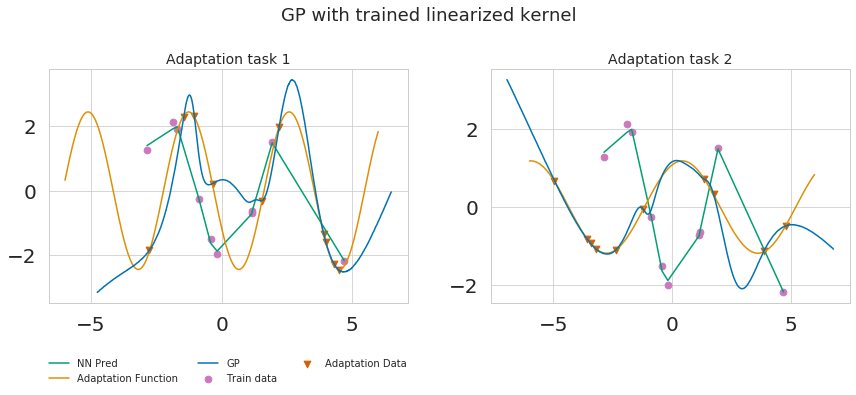

In [ ]:
# Visualize the outputs for our custom trained NN kernel GP (proposed method)
plot_storage_dict_custom(trained_storage_dict, method="trained", print_loss=False, print_test_mse=True)

Test MSE within range of adaptation data for task 1: 0.0428
Test MSE within range of adaptation data for task 2: 0.0318


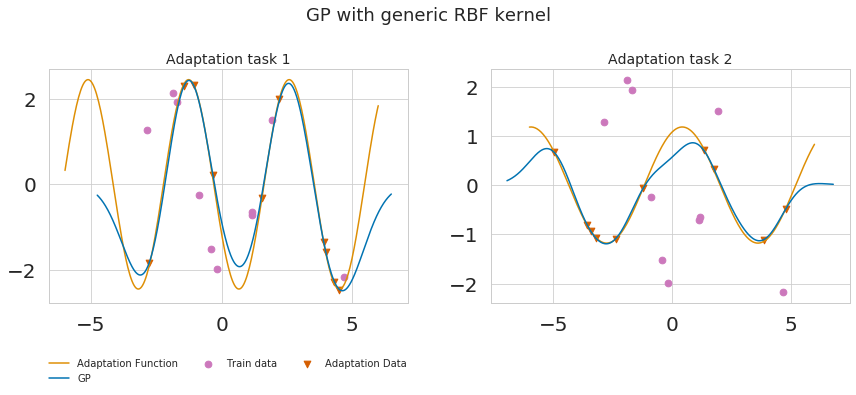

In [ ]:
# Visualize the outputs from RBF kernel (sklearn implementation)
plot_storage_dict_custom(rbf_kernel_storage_dict, method="rbf_kernel", print_loss=False, print_test_mse=True)

We can see that there are some difference between the results from our implementation and the results from the paper's implementation (plots in 4.1). These differences are likely due to different seeding with the PyTorch and sklearn/TensorFlow libraries. Overall, the patterns are largely the same. Most of these methods tend to fit the adaptation dataset very well, including the trained linearized kernel (suggesting that it is successful in transfering learning from the previously fit neural network).

One discrepency is that our untrained linearized kernel provides a better fit than the authors' untrained linearized kernel. We believe their result is the correct one (the one we "should see"), since there is no reason to believe that a kernel based on the Jacobian of an untrained model (with randomly intialized weights) should do well in fitting to adaptation data. Even though, we are also not excluding the fact that the GP with a random kernel would still be able to fit the new task well, since the task is too simple.  Therefore, more exploration is necessary to understand whether our result is due to a bug that lies deeper in the model implementation or there is a different underlying explanation.

### 5. Transfer learning experiments

To understand when the finite NTK performs well on transfer learning tasks and when it does not, we perform a variety of experiments on both contrived and real-world data, varying both the complexity of the transfer learning task and the number of adaptation points used. For each method and transfer learning scenario, we measure the test MSE within the range of adaptation data, as described above.

#### 5.1 Sinusoids (toy data sets)

Rather than generating random sinusoidal data as we did in the example above, we now construct more controlled transfer learning experiments by sampling training points from 

$$
y=\sin(x)
$$

and adaptation points from 

$$
y=\sin(x+b)
$$ 

for $b \in [-\pi/4,-\pi/2,-3\pi/4,-\pi]$. These values correspond to  increasingly shifted versions of the original training data and hence increasingly difficult transfer learning tasks, which we refer to as Adaptation Task 1, 2, 3, and 4. For each method and adaptation task, we also vary the number of adaptation points within $[10,12,...,30]$ in order to assess predictive performance in scenarios where differing volumes of target data are available.

There are three key takeaways that we can draw from the plots below. First, we notice that as the number of adaptation points increases, the test MSE decreases. This makes sense because we measure test MSE by comparing the GP predictions against the adaptation function. Hence, performing GP inference over more adaptation data should generally improve predictive performance. Second, and more interestingly, the finite NTK method (orange) is consistently outperformed by the GP with a generic RBF kernel. Even when the training and adaptation data are quite similar (Adaptation Task 1), it appears that using a generic kernel is superior. Further, we notice that as the training and adaptation data become more different (and the adaptation task becomes more difficult), the RBF kernel method appears to outperform the proposed method by an increasing amount. Third, the performances of the finite NTK and RBF kernel GPs are most similar when the number of adaptation points is small. This is intuitive because as the number of adaptation points increases, the benefit of the embedded inductive biases diminishes.

These observations reveal that the proposed method may only be useful when the adaptation (target) data and the training (source) data are very similar or when the volume of adaptation data available is very low. When the adaptation tasks are only slightly different or the number of adaptation points is reasonable, however, using a GP with a trained linearized kernel for transfer learning seems to offer worse predictive performance than simply using a GP with a generic RBF kernel.

In [ ]:
# Set parameters for sinusoids
A = 1
w = 1
b_list = [0, -np.pi/4, -np.pi/2, -3*np.pi/4, -np.pi]

# Get the test MSE results for shifted sinusoids experiment
sinusoid_mses, sinusoid_dict = get_mse_shifted_sinusoids(n_train_points=10, n_adaptation_points_list=np.arange(10,32,2), A=A, w=w, b_list=b_list)

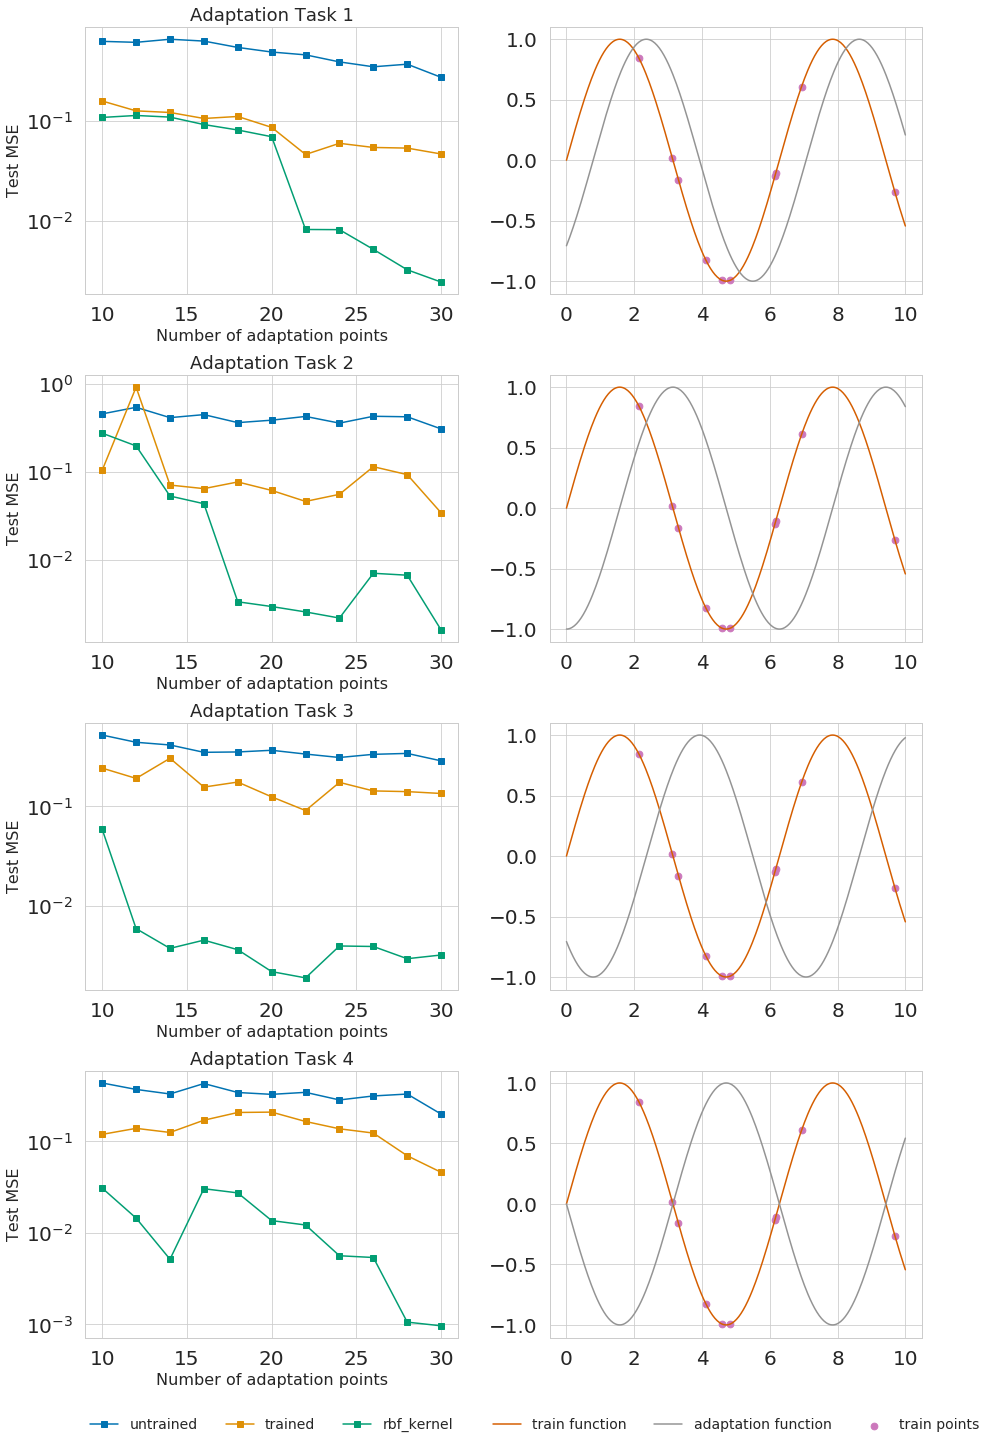

In [ ]:
# Plot results of shifted sinusoid experiment
plot_mse_shifted_sinusoids(sinusoid_mses, sinusoid_dict, n_adaptation_points_list=np.arange(10,32,2), A=A, w=w, b_list=b_list, savefig=False)

#### 5.2 Electricity consumption (real-world data set)

We also apply the finite NTK method to a real-world domain adaptation task and compare its performance with a GP that uses an RBF kernel.
We utilize the GEFCOM2012 electricity consumption dataset, which consists of hourly electricity consumption in kW for a US utility in 20 zones in the US, and hourly temperature measurements at 11 weather stations. The data range from 2004 to 2007. For all adaptation scenarios, we utilize the 10am values (of both electricity consumption and temperature measurements) to obtain daily measurements, and we utilize all 11 weather station temperature measurements as the inputs $X$.

We consider three different scenarios:
* **Scenario 1**: "Same years, different zones": training on the same years and adapting to / testing on different zones:
    * Training data: 
        * Y: electricity consumption for zone 1 (in 2004)
        * X: temperatures for zone 1 at 11 weather stations (in 2004)
    * Adaptation data:
        * Y: electricity consumption for zone 5 (in 2004)
        * X: temperatures for zone 2 at 11 weather stations  (in 2004)
* **Scenario 2**: "Same zones, different years": training on the same zones and adapting to / testing on different years
    * Training data: 
        * Y: electricity consumption for zone 1 (in 2004)
        * X: temperatures for zone 1 at 11 weather stations (in 2004)
    * Adaptation data:
        * Y: electricity consumption for zone 1 (in 2006)
        * X: temperatures for zone 1 at 11 weather stations (in 2006)
* **Scenario 3**: "Different years, different zones": training on different years and adapting to /testing on different zones
    * Training data: 
        * Y: electricity consumption for zone 1 (in 2004)
        * X: temperatures for zone 1 at 11 weather stations (in 2004)
    * Adaptation data:
        * Y: electricity consumption for zone 5 (in 2006)
        * X: temperatures for zone 5 at 11 weather stations (in 2006)

Below we plot the test MSE on 100 held-out observations from the same zone and year as the adaptation data. From the histograms, we observe that each of these adaptation tasks is quite challenging because the distribution of targets (electricity consumption) is quite different between train and test. We observe that the test MSE decreases as the number of adaptation points increases, consistent with intuition and with the results from the toy sinusoidal example. Across scenarios, the RBF kernel (with a different length scale parameter, tuned on the train data) outperforms the finite NTK method (with trained and untrained neural network). We also observe that the gap between the trained and untrained NTK method generally increases as the number of adaptation points increases.

The wide gap between the performance of the finite NTK and the RBF kernel method may be due to the training and adaptation data having distributions that are too dissimilar for inductive biases to be useful for transfer. In particular, for this dataset, the relationship between temperatures across weather stations and the electricity consumption at a given zone are likely to be very different for each zone (based on geographic proximity), rendering the learned weights less transferable across zones. Another possibility is neural network architecture and the noise hyperparameter in the Gaussian likelihood used in the NTK methods: in this notebook, we do not perform comprehensive tuning of learning parameters (learning rate, hidden nodes, momentum, epochs) and the noise parameter is set deterministically rather than tuned to the training data for the NTK methods (whereas with the RBF kernel, length-scale and noise are tuned to the train data). Yet another possible explanation is that the assumption of homoskedastic noise may not be appropriate for this task: heteroscedastic Gaussian likelihood may be more appropriate.

Therefore, while the illustrated results do not point to a clear conclusion, the results suggest that RBF kernels may yield comparable or superior performance on highly dissimilar adaptation tasks.

In [ ]:
# Download data (electricity consumption)
%cd /work
!curl -OL https://www.dropbox.com/s/epj9b57eivn79j7/GEFCom2012.zip
!unzip GEFCom2012.zip

In [ ]:
# Load electricity consumption data
X, Y = load_data()
N_ADAPTATION_POINTS_LIST = np.arange(10, 32, 2)

In [60]:
# block calls to print
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    task_1_dict = get_mse_results_dict(X, Y, N_ADAPTATION_POINTS_LIST = N_ADAPTATION_POINTS_LIST, 
                                        N_INPUT_FEATURES = 11, N_OUTPUT_FEATURES = 1,
                                        TRAIN_YEAR = [2004], TEST_YEAR = [2004], HOUR = 10, 
                                        TRAIN_ZONE_ID = 1, TEST_ZONE_ID = 5, 
                                        N_TEST_POINTS = 200, N_HID = 50, N_EPOCHS = 30, BATCHES_PER_EPOCH = 3, LR = 1e-4, MOMENTUM = 0, 
                                        SEED = 0, use_linearstrategy = False)

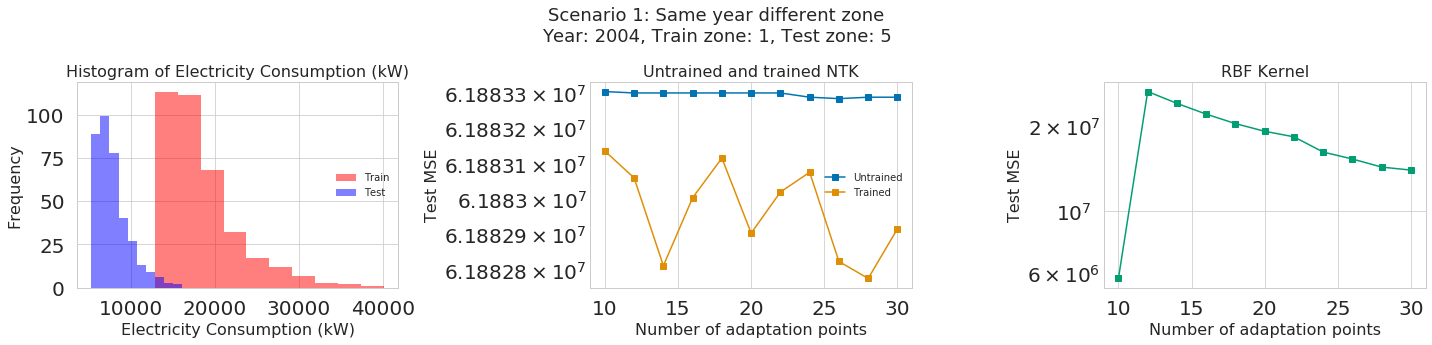

In [115]:
plot_mse_results(X, Y, task_1_dict, N_ADAPTATION_POINTS_LIST,
                    title = "Scenario 1: Same year different zone\nYear: 2004, Train zone: 1, Test zone: 5", 
                    train_zone = 1, test_zone = 5, train_year = 2004, test_year = 2004, hour = 10)

In [46]:
# block calls to print
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    task_2_dict = get_mse_results_dict(X, Y, N_ADAPTATION_POINTS_LIST = N_ADAPTATION_POINTS_LIST, 
                                        N_INPUT_FEATURES = 11, N_OUTPUT_FEATURES = 1,
                                        TRAIN_YEAR = [2004], TEST_YEAR = [2006], HOUR = 10, 
                                        TRAIN_ZONE_ID = 1, TEST_ZONE_ID = 1, 
                                        N_TEST_POINTS = 200, N_HID = 50, N_EPOCHS = 30, BATCHES_PER_EPOCH = 3, LR = 1e-4, MOMENTUM = 0, 
                                        SEED = 0, use_linearstrategy = False)

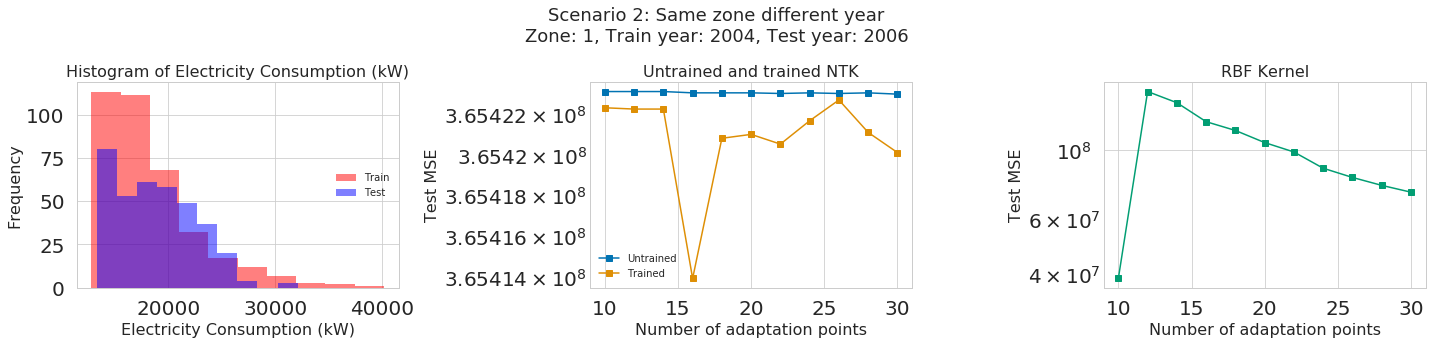

In [116]:
plot_mse_results(X, Y, task_2_dict, N_ADAPTATION_POINTS_LIST,
                    title = "Scenario 2: Same zone different year\nZone: 1, Train year: 2004, Test year: 2006", 
                    train_zone = 1, test_zone = 1, train_year = 2004, test_year = 2006, hour = 10)

In [49]:
# block calls to print
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    task_3_dict = get_mse_results_dict(X, Y, N_ADAPTATION_POINTS_LIST = N_ADAPTATION_POINTS_LIST, 
                                        N_INPUT_FEATURES = 11, N_OUTPUT_FEATURES = 1,
                                        TRAIN_YEAR = [2004], TEST_YEAR = [2006], HOUR = 10, 
                                        TRAIN_ZONE_ID = 1, TEST_ZONE_ID = 5, 
                                        N_TEST_POINTS = 200, N_HID = 50, N_EPOCHS = 30, BATCHES_PER_EPOCH = 3, LR = 1e-4, MOMENTUM = 0, 
                                        SEED = 0, use_linearstrategy = False)

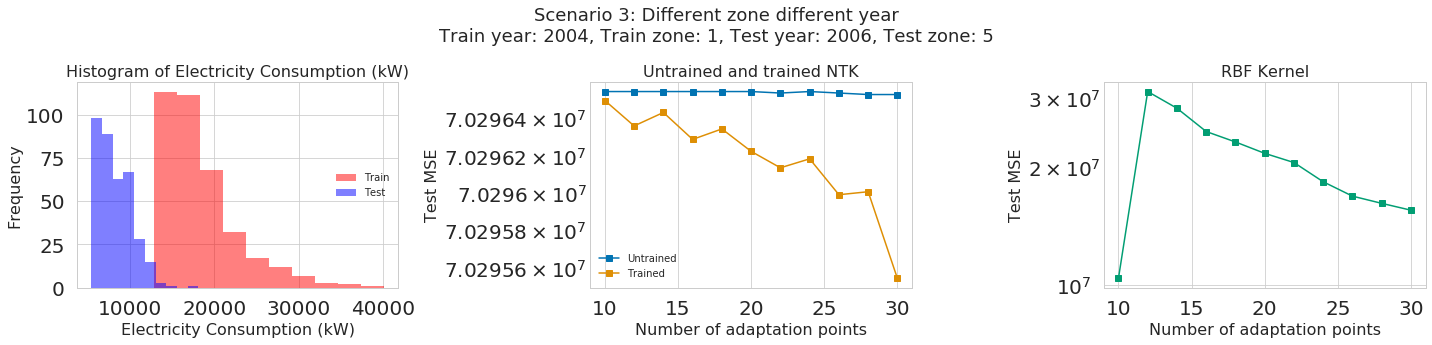

In [117]:
plot_mse_results(X, Y, task_3_dict, N_ADAPTATION_POINTS_LIST, 
                    title = "Scenario 3: Different zone different year\nTrain year: 2004, Train zone: 1, Test year: 2006, Test zone: 5", 
                    train_zone = 1, test_zone = 5, train_year = 2004, test_year = 2006, hour = 10)

### 6. Future work

In this notebook, we compared the predictive performance of the proposed finite NTK method to GPs with alternative kernels. In our experiments, we found that GPs with RBF kernels consistently outperformed the proposed method, suggesting that the inductive biases learned by the trained neural network and adapted into a GP hindered predictive performance. However, the relatively strong performance of RBF kernel GPs could simply be the result of conducting overly simplistic experiemnts that would not benefit from transfer learning to begin with. Alternatively, it could be that our experiments provide too much adaptation data for the benefits of transfer learning via the finite NTK method to become apparent. Hence, future work could compare the performance of these methods for scenarios in which the adaptation task is: 1) significantly more complex, and 2) particularly data scarce.

For experiments in which the benefits of transfer learning may be more apparent, we would also recommend comparing the predictive performance and computational efficiency of the finite NTK with those of traditional methods for transfer learning, including neural network finetuning. Further, it would also be interesting to investigate the effect of different neural network architectures on the performance of the proposed method.

### 7. Broader Impact

#### Potential positive broader impacts:

- **Environmental impact:** The general value-add of this fast adaptation framework is that it allows for transfer learning without retraining or fine tuning of huge models. By avoiding retuning or additional tuning of large models like BERT, companies and users save computational resources. Saving computational resources not only saves funds, but it also puts less environmental strain on the planet (training large models requires a great deal of electricity and can have a large carbon footprint).
- **Uncertainty estimates:** By converting neural network models into GPs, this method of transfer learning provides more tools for uncertainty estimates for downstream tasks. Generally, data scientists are more comfortable providing uncertainty estimates with GP models than with traditional neural networks. Therefore, doing transfer learning with GPs could lead to data scientists providing more frequent estiamtes of uncertainty, which might help practioners make more principled decisions on downstream tasks.

#### Potential negative broader impacts:

- **Inductive biases:** By providing a less expensive way to do transfer learning, linearized neural nets could lead to more frequent use of transfer learning from large models. However, it is possible that the inductive biases of these large models contain non-generalizable features, which could lead to biased predictions in comparison to training a model from scratch. For example, prior reports have found Amazon's facial recogntion software to be biased, with poorer performance specifically on people with darker complexions. Based on the results of this paper, a data scientist might decide to implement a linearized neural network transfer of Amazon's model for facial recognition, rather than create their own facial recognition software from scratch. This could cause the data scientist's model to learn poor behavior from Amazon's model, leading to poor predictions for people of darker complexions. A model trained from scratch on a dataset that is more similar to the particular use case, however, may not have learned these biases. Hence, it is particularly important to be cognizant of inductive biases when the training data differs systematically from the data used in adaptation tasks.
- **Too much certainty in the transfer of learning:** In some cases, the transfer of learning from linearized neural nets may not be completely robust. For example, it is unclear whether attempting to linearize and transfer learn from the BERT language model would produce a comparable GP model for adaptation tasks. It could be that some models are so complex (such as BERT) that the linearized approximation proposed by the paper does a poor job of actually transferring all of their learning to new models. In this case, a data scientist may think that their transferred model is as powerful and accurate for language tasks as BERT, when really it is not. This could give practioners undue certainty in their predictions for downstream tasks and lead to negative consequences. For example, a data scientist who attempts to linearize and transfer learn from BERT to a spam email detection machine learning model may blindly release it to the community without proper testing. However, the inaccurate transfer of learning from BERT could lead to poor implementation of the email spam filter, causing a greater number of spam emails to be received and important non-spam emails flagged as spam.

### 8. Conclusion

In both our toy sinusoidal data example and our experiments using real-world electricity consumption data, we found that the proposed finite NTK method was generally outperformed by GPs with generic RBF kernels in terms of predictive accuracy on adaptation tasks. This suggests that for the (target) adaptation tasks considered here, embedding GPs with kernels that encode the inductive biases of a neural network trained on a similar source task *hindered* predictive performance in comparison to using GPs with RBF kernels.

In addition, we found that the finite NTK method may offer the greatest advantages over the RBF kernel method under two conditions: 1) the target task is very similar to the source task, and 2) the number of adaptation points is very small. Even under the most promising versions of these conditions attempted in our experiments, however, the finite NTK was outperformed by the RBF kernel. 

This highlights a serious flaw in the paper: the authors avoid directly comparing their finite NTK method with the generic kernels (e.g. RBF). Because the authors fail to show learning that outperforms a generic kernel, they fail to demonstrate "learning transfer" beyond what generic kernels already provide. In fact, the only time they do compare their method to a generic kernel, they find no relative improvement from their method (see their Figure 6, comparison with RBF kernel).

Given the relatively strong performance of the RBF kernel method, we suspect that the experiments performed here are perhaps too simple to warrant using transfer learning at all. It could be that we'd only find value-add from the finite NTK method when transferring learning from very large models (e.g. BERT) for complex downstream tasks (e.g. classifying news articles). Still, when implementing experiments similar to those shown in the paper, we fail to find advantages of the finite NTK method over generic kernel methods. Therefore, this method may not be as powerful or as useful as the paper suggests.

### 9. References

Maddox, W. J., Tang, S., Moreno, P. G., Wilson, A. G. (2021). Fast Adaptation with Linearized Neural Networks. In *Proceedings of the 24th International Conference on Artificial Intelligence and Statistics (AISTATS) 2021*. https://arxiv.org/abs/2103.01439

Maddox, W. J. Transfer Learning via Linearized Neural Networks, (2021), Github repository. https://github.com/amzn/xfer/tree/master/finite_ntk 

Obst, D., Ghattas, B., Cugliari, J., Oppenheim, G., Claudel, S., Goude, Y. (2021). Transfer Learning for Linear Regression: a Statistical Test of Gain. https://arxiv.org/abs/2102.09504 

Tao Hong, Pierre Pinson and Shu Fan, "Global energy forecasting competition 2012", International Journal of Forecasting, vol.30, no.2, pp 357-363, April-June, 2014.

GEFCom2012 Load Forecasting Data: https://www.kaggle.com/c/global-energy-forecasting-competition-2012-load-forecasting/overview/description

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.